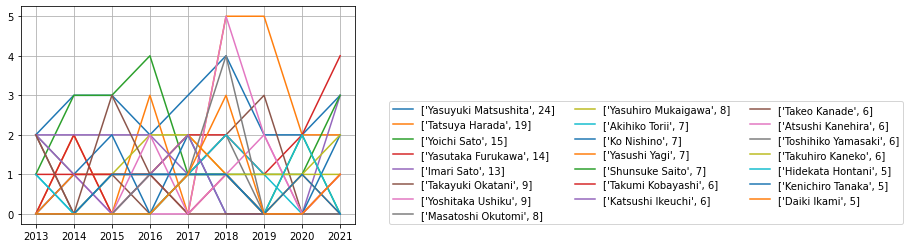

In [19]:
import re
import matplotlib.pylab as plt

# configurations
yearFrom=2013
yearTo=2022
toshow=5

# Regular expressions for Japanese-like and non-Japanese 
sjppat="\
^\
([AIUEO]|[BGKMNR][aiueo]|[BGKMNR]y[auo]|D[aeo]|S[aueo]|Sh[iu]|T[aeo]|Tsu|Z[aueo]|Y[auo]|H[aieo]|J[aiuo]|Ch[aiuo]|D[aeo]|Wa|Fu)\
([nht]|[aiueo]|[bgkmnr][aiueo]|[bgkmnr]y[auo]|d[aeo]|s[aueo]|sh[iu]|t[aeo]|tsu|z[aueo]|y[auo]|h[aieo]|j[aiuo]|ch[aiuo]|d[aeo]|wa|fu)*?\
\s\
([AIUEO]|[BGKMNR][aiueo]|D[aeo]|S[aueo]|Sh[iu]|T[aeo]|Tsu|Z[aueo]|Y[auo]|H[aieo]|J[aiuo]|Ch[aiuo]|D[aeo]|Wa|Fu)\
([nht]|[aiueo]|[bgkmnr][aiueo]|d[aeo]|s[aueo]|sh[iu]|t[aeo]|tsu|z[aueo]|y[auo]|h[aieo]|j[aiuo]|ch[aiuo]|d[aeo]|wa|fu)*?\
$\
"
snjppat="\
^(.+?an\s.+?an)$|^Yu\sYu$|^He|He$|^Han|Han$|^Sun|Sun$|^Ji|Ji$|^Jia|Jia$|^Su|Su$|^Guo|Guo$|^Zou|Zou$|^Yuan|Yuan$|\
^Dai\s|\sDai$|^Ma\s|\sMa$|^Na\s|\sNa$|^Yan\s|\sYan$|^Bai\s|\sBai$|^Tan\s|\sTan$|^Gan\s|\sGan$|^Yan\s|\sYan$|^Tao\s|\sTao$|^Ren\s|\sRen$|\
^Yuan\s|\sYuan$|^Hen\s|\sHen$|^Cho\s|\sCho$|^Ji\s|\sJi$|^Jia\s|\sJia$^Ge\s|\sGe$|^Gao\s|\sGao$|^Hao\s|\sHao$|^Choi\s|\sChoi$|^Ke\s|\sKe$|\
^Zuo\s|\sZuo$|^Bo\s|\sBo$|^Du\s|\sDu$|^Ni\s|\sNi$|^Bi\s|\sBi$|^Wan\s|\sWan$|^Heo\s|\sHeo$|^Jason\s|\sJason$|^Shi\s|\sShi$|^Des|\sDes|\
^Yuhe\s|\sYuhe$|^Fu\s|\sFu$|^Yao\s|\sYao$|^Mao\s|\sMao$|^Ryan\s|\sRyan$|^Niu\s|\sNiu$|^Gu\s|\sGu$|^Mo\s|\sMo$|\sYu$|^Mu\s|\sMu$|^Nie\s|\sNie$\
|^Sui\s|\sSui$|^Chan\s|\sChan$|^Guan\s|\sGuan$|^Yun\s|\sYun$|^Bin\s|\sBin$|^Jan\s|\sJan$\
|jie|iao|ia|oo|ee|chao|toni|gudo|aen|au|Zeku|zeku|rara|Minji|minji|nru|oha|Gurari|wane|hao|Dakai|Inkyu|Dae|Bei|Ahn|Kenneth|Amit\
|Meina|Minh|hui|Zabih|Bodo|Konu|Jane|Noh|Man|^Ori\s|You$|Gui|Yue|Joe|Matt|Menon|Suin|Munro|Watson|zadeh|\sHou|Shujon|Aron|Naza|Minkyo\
|Doron|Jain|Garon|Suh|Rahtu|Junho|Bera|Sachin|Moin|Samitha|Mukundan|Jayasekara|Samitha|Sanath|Basu|yuan|Ou$|Nirat|Jonathan|Bao|Yani\
|Juge|Jose|Mike|Jae|Juan|gege|Emonet|dana|Niket|Oneata|Shuchin"
dlm=",\s"

# main program
total, nonjp, jppaper = [], [], []
hist={}
for year in range(yearFrom,yearTo):
    fname='./CVPR'+str(year)+'_full_author_list'
    f = open(fname, 'r')
    lLines = f.read().splitlines()
    f.close()

    ncount=0
    title, authors, jptitle, jpauthors, nonjptitle, nonjpauthors = [], [], [], [], [], []
    for line in lLines:
        ndet=ncount%3
        if ndet==0:
            title.append(line)
        elif ndet==1:
            authors.append(line)
            authorList=re.split(dlm,line)
            bMatch=0
            for author in authorList:
                rmat=re.search(sjppat,author)
                rstop=re.search(snjppat,author)
                if rmat: # Japanese-like list
                    if not rstop: # Non-Japanese name filtering
                        # make individual statistics
                        if author in hist.keys():
                            if str(year) in hist[author]:
                                hist[author][str(year)]+=1
                            else:
                                hist[author][str(year)]=1
                        else:
                            hist[author]={str(year):1}
                        bMatch=1
            if bMatch==1:
                # make title, author list
                jptitle.append(title[-1])
                jpauthors.append(line)
            else:
                # make non-japanese title, author list (no use, just for check)
                nonjptitle.append(title[-1])
                nonjpauthors.append(line)
        ncount+=1
    # global statistics
    total.append(len(authors))
    nonjp.append(len(nonjpauthors))
    jppaper.append(len(jpauthors))

# dictionary to list conversion with sorting by year
sumhist, detail = [], []
for author in hist.keys():
    for year in range(yearFrom,yearTo):
        sYear=str(year)
        if sYear not in hist[author].keys():
            hist[author][sYear]=0
    myList = sorted(hist[author].items(), key=lambda x:x[0])
    x, y = zip(*myList)
    sumhist.append(sum(y))
    detail.append([author,sum(y),y])

# sorting by total number of publications
indices = [*range(len(sumhist))]
sorted_indices = sorted(indices, key=lambda i:-sumhist[i])
sumhist = [sumhist[i] for i in sorted_indices]
detail = [detail[i] for i in sorted_indices]

# filtering of the list to plot
show_indices=[]
for i in range(0,len(sumhist)):
    if sumhist[i] >= toshow:
        show_indices.append(i)

# output and plot of the results
#print([detail[i] for i in show_indices])
fig = plt.figure()
for i in show_indices:
    plt.plot(x, detail[i][2],label=detail[i][0:2])
plt.grid()
plt.legend(loc=(1.1, 0),ncol=3)
fig.savefig("test.png")
plt.show()

ICCV2013 ...
https://openaccess.thecvf.com/ICCV2013
Error: no all link found
https://openaccess.thecvf.com/ICCV2013
parsing success
ICCV2015 ...
https://openaccess.thecvf.com/ICCV2015
Error: no all link found
https://openaccess.thecvf.com/ICCV2015
parsing success
ICCV2017 ...
https://openaccess.thecvf.com/ICCV2017
Error: no all link found
https://openaccess.thecvf.com/ICCV2017
parsing success
ICCV2019 ...
https://openaccess.thecvf.com/ICCV2019
Error: no all link found
https://openaccess.thecvf.com/ICCV2019.py?day=2019-10-29
https://openaccess.thecvf.com/ICCV2019.py?day=2019-10-30
https://openaccess.thecvf.com/ICCV2019.py?day=2019-10-31
https://openaccess.thecvf.com/ICCV2019.py?day=2019-11-01
parsing success
ICCV2021 ...
https://openaccess.thecvf.com/ICCV2021
https://openaccess.thecvf.com//ICCV2021?day=all
parsing success


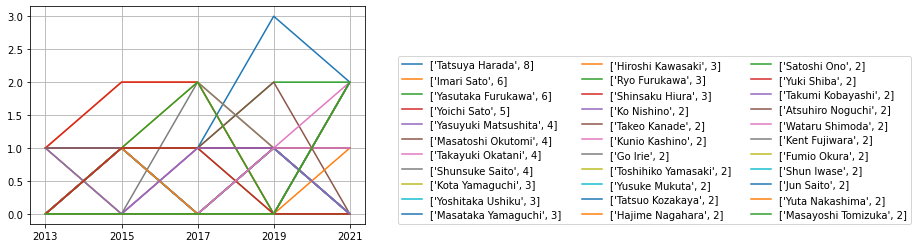

In [54]:
import re
import requests
from bs4 import BeautifulSoup
import bibtexparser
import matplotlib.pylab as plt


class set_param:

    def __init__(self, site, conf_prefix, yearFrom, yearTo, interval, toShow):
        self.site = site
        self.conf_prefix = conf_prefix
        self.yearFrom = yearFrom
        self.yearTo = yearTo
        self.toShow = toShow
        self.interval = interval

# configurations
param = set_param('https://openaccess.thecvf.com/', 'ICCV', 2013, 2022, 2, 2)
#https://openaccess.thecvf.com/ICCV2021


######################
# main program
######################
def main(param): 
    
    sjppat, snjppat, dlm = regex_config()
    total, nonjp, jppaper, bMatch = 0, 0, 0, 0
    hist = {}
    for year in range(param.yearFrom, param.yearTo, param.interval):
        conf = param.conf_prefix + str(year)
        print(conf,'...')
        normal, authorss, titles = parse_source(param.site, conf)
        if normal < 0: 
            print('parsing failed...')
        else:
            print('parsing success')

        title, jptitle, jpauthors, nonjptitle, nonjpauthors = [], [], [], [], []
        ii = 0
        for authors in authorss:
            for author in authors:
                bMatch=0
                rmat=re.search(sjppat,author)
                rstop=re.search(snjppat,author)
                if rmat and not rstop: # Japanese-like list and Non-Japanese name filtering
                    # make individual statistics
                    if author in hist.keys():
                        if str(year) in hist[author]:
                            hist[author][str(year)]+=1
                        else:
                            hist[author][str(year)]=1
                    else:
                        hist[author]={str(year):1}
                    bMatch=1
                if bMatch:
                    # make title, author list
                    jptitle.append(titles[ii])
                    jpauthors.append(author)
                else:
                    # make non-japanese title, author list (no use, just for check)
                    nonjptitle.append(titles[ii])
                    nonjpauthors.append(author)
            ii += 1
            
        # global statistics
        total += len(authors)
        nonjp += len(nonjpauthors)
        jppaper += len(jpauthors)
    """
    ii = 0
    for jpauthor in jpauthors:
        print(jpauthor,'\n', jptitle[ii], '\n')
        ii += 1
    """     
    # dictionary to list conversion with sorting by year
    sumhist, detail = [], []
    for author in hist.keys():
        for year in range(param.yearFrom,param.yearTo,param.interval):
            sYear=str(year)
            if sYear not in hist[author].keys():
                hist[author][sYear]=0
        myList = sorted(hist[author].items(), key=lambda x:x[0])
        x, y = zip(*myList)
        sumhist.append(sum(y))
        detail.append([author,sum(y),y])

    # sorting by total number of publications
    indices = [*range(len(sumhist))]
    sorted_indices = sorted(indices, key=lambda ii:-sumhist[ii])
    sumhist = [sumhist[ii] for ii in sorted_indices]
    detail = [detail[ii] for ii in sorted_indices]

    # filtering of the list to plot
    show_indices=[]
    for ii in range(0,len(sumhist)):
        if sumhist[ii] >= param.toShow:
            show_indices.append(ii)

    # output and plot of the results
    #print([detail[ii] for ii in show_indices])
    fig = plt.figure()
    for ii in show_indices:
        plt.plot(x, detail[ii][2],label=detail[ii][0:2])
    plt.grid()
    plt.legend(loc=(1.1, 0),ncol=3)
    fig.savefig("test.png")
    plt.show()


def parse_target(targetsite):
    normal = -1
    author, title = [], []
    
    print(targetsite)
    try:
        response = requests.get(targetsite)
    except requests.exceptions.RequestException as e:
        print("Error: ",e)
        return normal, author, title

    bs = BeautifulSoup(response.text, 'html.parser')
    titles = bs.find_all('dt',{'class':'ptitle'})
    ddlines = bs.find_all('dd')

    ii = 0
    for line in ddlines:
        contentline = line.get_text()
        contentline = re.sub('[^A-z,][\s\n]+','',contentline)
        contentline = re.sub('\n','',contentline)
        if contentline[0:5] == '[pdf]':
            pass
        elif re.search('[Bb]ack',contentline):
            pass
        else:
            author.append(re.split(',',contentline))
            title.append(titles[ii].get_text())
            ii += 1

    normal = 1
    return normal, author, title


def parse_source(site, conf): 
    normal = -1 
    author, title = [], [] 
    
    rootsite = site + conf
    print(rootsite)
    try:
        response = requests.get(rootsite)
    except requests.exceptions.RequestException as e:
        print("Error: ",e)
    
    bs = BeautifulSoup(response.text, 'html.parser')
    links = bs.find_all('a')
    
    allpageFound = 0
    indpageFound = 0
    for link in links:
        linksite = link.get('href')
        if re.search('all$',str(linksite)):
            allpageFound = 1
            targetsite = site + linksite
            normal, author, title = parse_target(targetsite)
            return normal, author, title
    
    if not allpageFound: 
        print("Error: no all link found")
        for link in links:
            linksite = link.get('href')
 
            if re.search('20[0-2][0-9]-[01][0-9]-[0-3][0-9]',str(linksite)):
                indpageFound = 1
                targetsite = site + linksite
                normal, author_tmp, title_tmp = parse_target(targetsite)
                if normal > 0:
                    author=author+author_tmp
                    title=title+title_tmp
                else:
                    return normal, author, title
        if indpageFound:
            return normal, author, title
        else:
            normal, author, title = parse_target(rootsite)
            return normal, author, title
            

def regex_config():

    # Regular expressions for Japanese-like and non-Japanese 
    sjppat="\
^\
([AIUEO]|[BGKMNR][aiueo]|[BGKMNR]y[auo]|D[aeo]|S[aueo]|Sh[iu]|T[aeo]|Tsu|Z[aueo]|Y[auo]|H[aieo]|J[aiuo]|Ch[aiuo]|D[aeo]|Wa|Fu)\
([nht]|[aiueo]|[bgkmnr][aiueo]|[bgkmnr]y[auo]|d[aeo]|s[aueo]|sh[iu]|t[aeo]|tsu|z[aueo]|y[auo]|h[aieo]|j[aiuo]|ch[aiuo]|d[aeo]|wa|fu)*?\
\s\
([AIUEO]|[BGKMNR][aiueo]|D[aeo]|S[aueo]|Sh[iu]|T[aeo]|Tsu|Z[aueo]|Y[auo]|H[aieo]|J[aiuo]|Ch[aiuo]|D[aeo]|Wa|Fu)\
([nht]|[aiueo]|[bgkmnr][aiueo]|d[aeo]|s[aueo]|sh[iu]|t[aeo]|tsu|z[aueo]|y[auo]|h[aieo]|j[aiuo]|ch[aiuo]|d[aeo]|wa|fu)*?\
$\
"
    snjppat="\
^(.+?an\s.+?an)$|^Yu\sYu$|^He|He$|^Han|Han$|^Sun|Sun$|^Ji|Ji$|^Jia|Jia$|^Su|Su$|^Guo|Guo$|^Zou|Zou$|^Yuan|Yuan$|\
^Dai\s|\sDai$|^Ma\s|\sMa$|^Na\s|\sNa$|^Yan\s|\sYan$|^Bai\s|\sBai$|^Tan\s|\sTan$|^Gan\s|\sGan$|^Yan\s|\sYan$|^Tao\s|\sTao$|^Ren\s|\sRen$|\
^Yuan\s|\sYuan$|^Hen\s|\sHen$|^Cho\s|\sCho$|^Ji\s|\sJi$|^Jia\s|\sJia$^Ge\s|\sGe$|^Gao\s|\sGao$|^Hao\s|\sHao$|^Choi\s|\sChoi$|^Ke\s|\sKe$|\
^Zuo\s|\sZuo$|^Bo\s|\sBo$|^Du\s|\sDu$|^Ni\s|\sNi$|^Bi\s|\sBi$|^Wan\s|\sWan$|^Heo\s|\sHeo$|^Jason\s|\sJason$|^Shi\s|\sShi$|^Des|\sDes|\
^Yuhe\s|\sYuhe$|^Fu\s|\sFu$|^Yao\s|\sYao$|^Mao\s|\sMao$|^Ryan\s|\sRyan$|^Niu\s|\sNiu$|^Gu\s|\sGu$|^Mo\s|\sMo$|\sYu$|^Mu\s|\sMu$|^Nie\s|\sNie$\
|^Sui\s|\sSui$|^Chan\s|\sChan$|^Guan\s|\sGuan$|^Yun\s|\sYun$|^Bin\s|\sBin$|^Jan\s|\sJan$\
|jie|iao|ia|oo|ee|chao|toni|gudo|aen|au|Zeku|zeku|rara|Minji|minji|nru|oha|Gurari|wane|hao|Dakai|Inkyu|Dae|Bei|Ahn|Kenneth|Amit\
|Meina|Minh|hui|Zabih|Bodo|Konu|Jane|Noh|Man|^Ori\s|You$|Gui|Yue|Joe|Matt|Menon|Suin|Munro|Watson|zadeh|\sHou|Shujon|Aron|Naza|Minkyo\
|Doron|Jain|Garon|Suh|Rahtu|Junho|Bera|Sachin|Moin|Samitha|Mukundan|Jayasekara|Samitha|Sanath|Basu|yuan|Ou$|Nirat|Jonathan|Bao|Yani|Kien\
|Juge|Jose|Mike|Jae|Juan|gege|Emonet|dana|Niket|Oneata|Shuchin|Gideon|Mehta|Yakui|Ahyun|Ruta|Yumin|Mazaheri|Guha|Himanshu|Narayanan|Ronen|Bengio|Osokin"

    dlm=",\s"
    
    return sjppat, snjppat, dlm

########################
##### main program #####
########################
main(param)
